In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

In [2]:
from helper import points_extraction, corners_unwarp, abs_sobel_thresh, mag_thresh, dir_threshold, hls_select
from helper import hist, find_lane_pixels, fit_polynomial, fit_poly, search_around_poly, measure_curvature_pixels
from helper import measure_curvature_real, region_of_interest

# Camera Calibration and Distortion Correction Steps

In [3]:
# make list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

(objpoints, imgpoints, retlist) = points_extraction(images, nx=9, ny=6)

Text(0.5,1,'Undistorted Image')

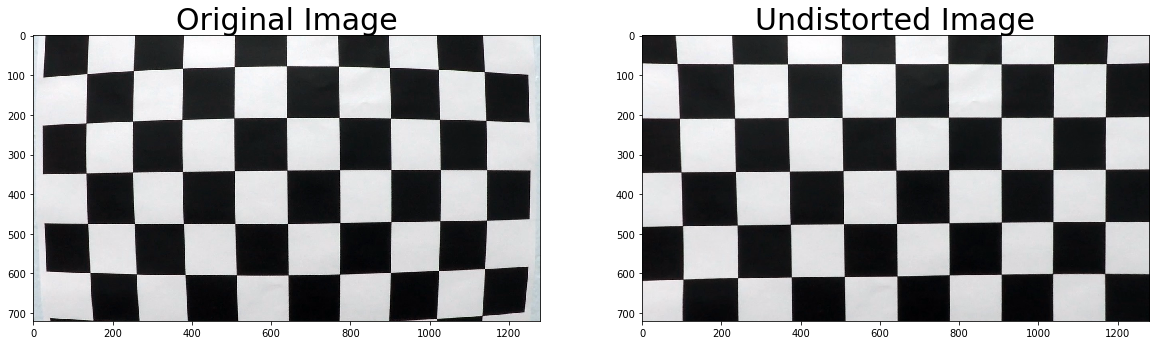

In [4]:
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)


dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# Color & Gradient Threshold Step

In [5]:
def color_gradient_pipline(img, s_thresh=(125, 255), sx_thresh=(50, 90), m_thresh=(55, 110)):
    img = np.copy(img)
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    img = np.copy(undist)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sx_binary = abs_sobel_thresh(l_channel, orient='x', sobel_kernel=5, sob_thresh=sx_thresh)
    
    # Magnitude
    mag_binary = mag_thresh(l_channel, sobel_kernel=9, mag_thresh=m_thresh)
    
    # Threshold color channel
    s_binary = hls_select(img, thresh=s_thresh)
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(s_binary == 1) | (sx_binary == 1) | (mag_binary == 1)] = 1

    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sx_binary), sx_binary, s_binary)) * 255
    return color_binary, combined_binary, sx_binary, s_binary, mag_binary

In [6]:
def show_color_gradient_pipline(img):
    # color_binary, combined_binary, sx_binary, s_binary = color_gradient_pipline(img, \
    #                                                                        s_thresh=(150, 255), \
    #                                                                        sx_thresh=(10,100))
    
    # color_binary, combined_binary, sx_binary, s_binary = color_gradient_pipline(image, \
    #                                                                        s_thresh=(125, 255), \
    #                                                                        sx_thresh=(25,90))

    # color_binary, combined_binary, sx_binary, s_binary = color_gradient_pipline(image, \
    #                                                                        s_thresh=(125, 255), \
    #                                                                        sx_thresh=(50,90), m_thresh=(55, 110))
    
    color_binary, combined_binary, sx_binary, s_binary, mag_binary = color_gradient_pipline(image, \
                                                                            s_thresh=(175, 250), \
                                                                            sx_thresh=(50,90), m_thresh=(55, 110))
                                                                                
    # Plot the result
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#     f.tight_layout()

#     ax1.imshow(sx_binary, cmap='gray')
#     ax1.set_title('sx_binary', fontsize=40)

#     ax2.imshow(s_binary, cmap='gray')
#     ax2.set_title('s_binary', fontsize=40)
#     plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(combined_binary, cmap='gray')
    ax1.set_title('Combined Image', fontsize=40)

    ax2.imshow(mag_binary, cmap='gray')
    ax2.set_title('mag_binary', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(sx_binary, cmap='gray')
    ax1.set_title('sx_binary', fontsize=40)

    ax2.imshow(s_binary, cmap='gray')
    ax2.set_title('s_binary', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

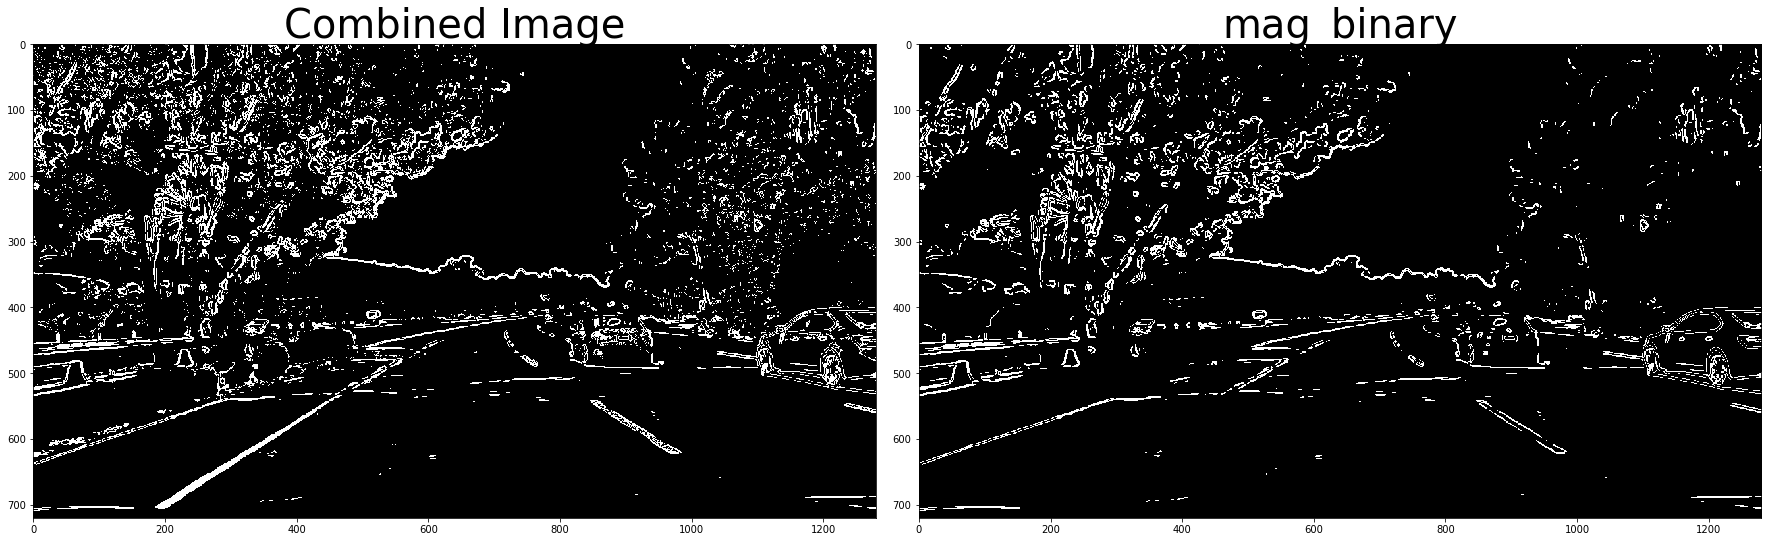

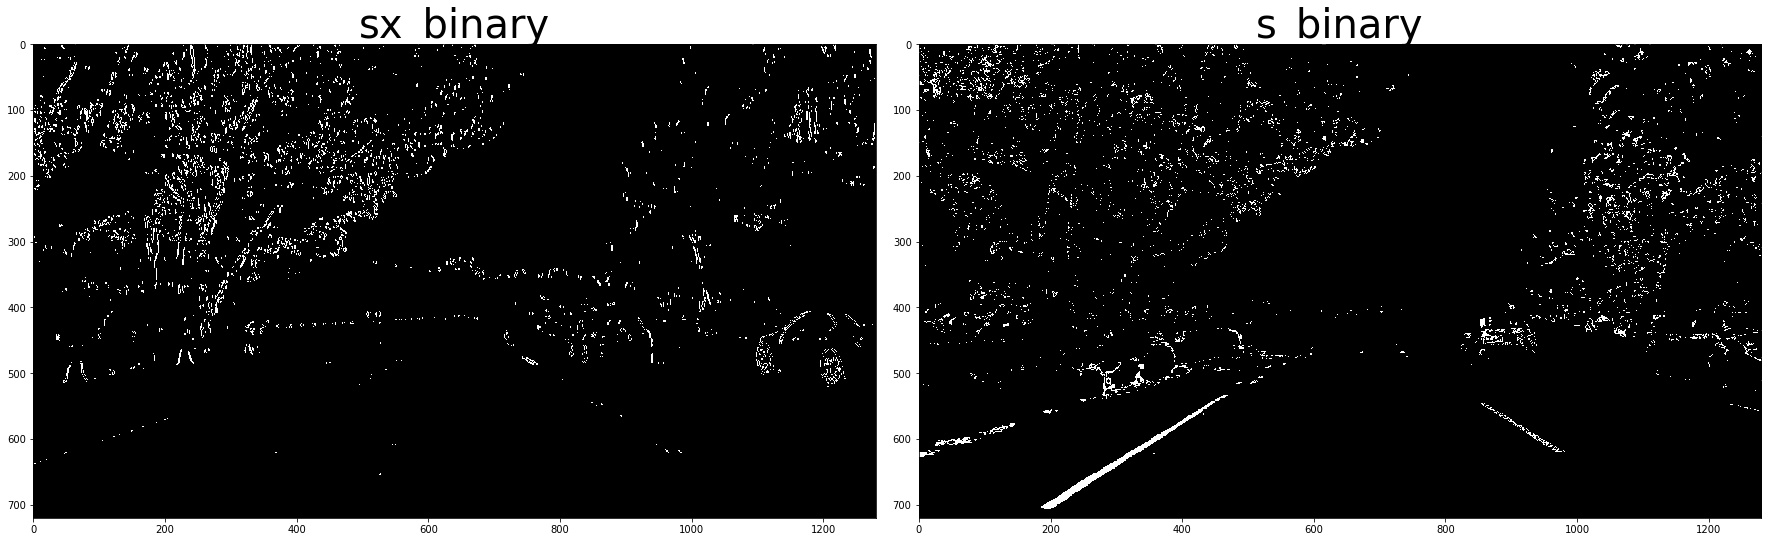

In [7]:
image = cv2.imread('test_images/test5.jpg')

show_color_gradient_pipline(image)

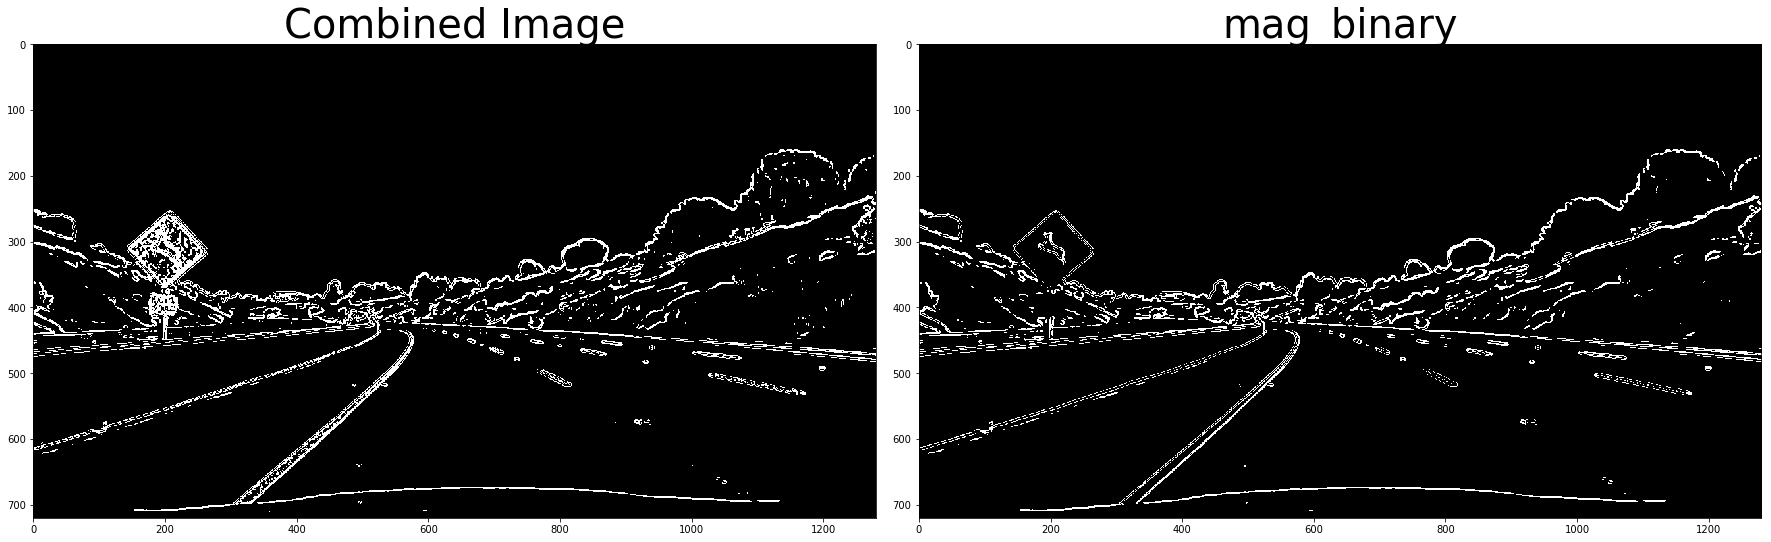

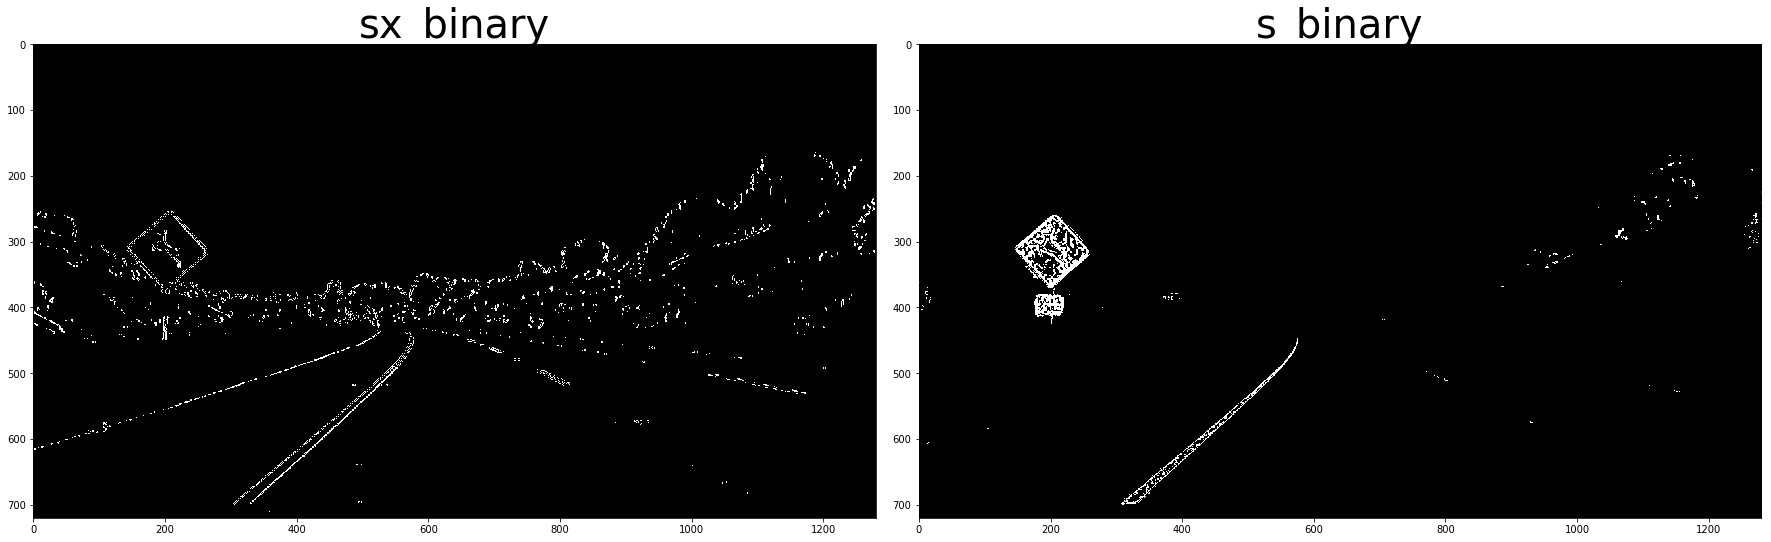

In [8]:
image = cv2.imread('test_images/test2.jpg')

show_color_gradient_pipline(image)

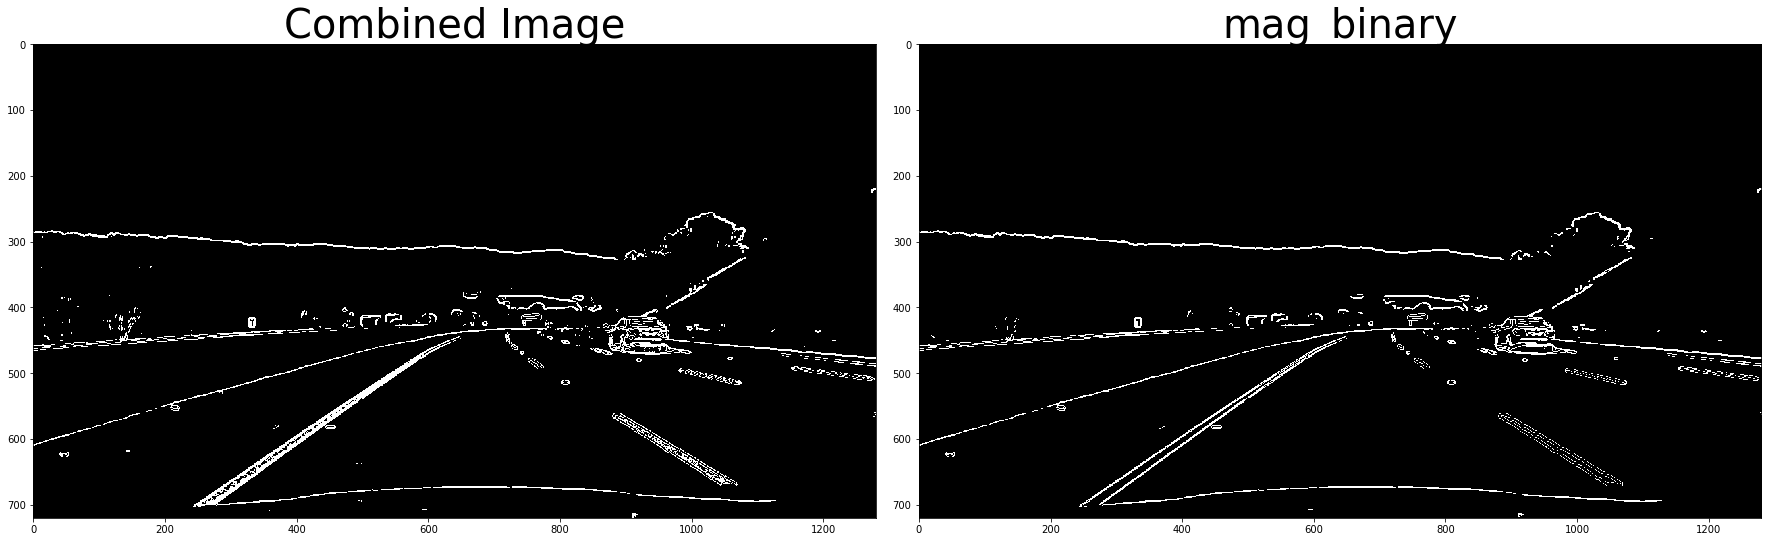

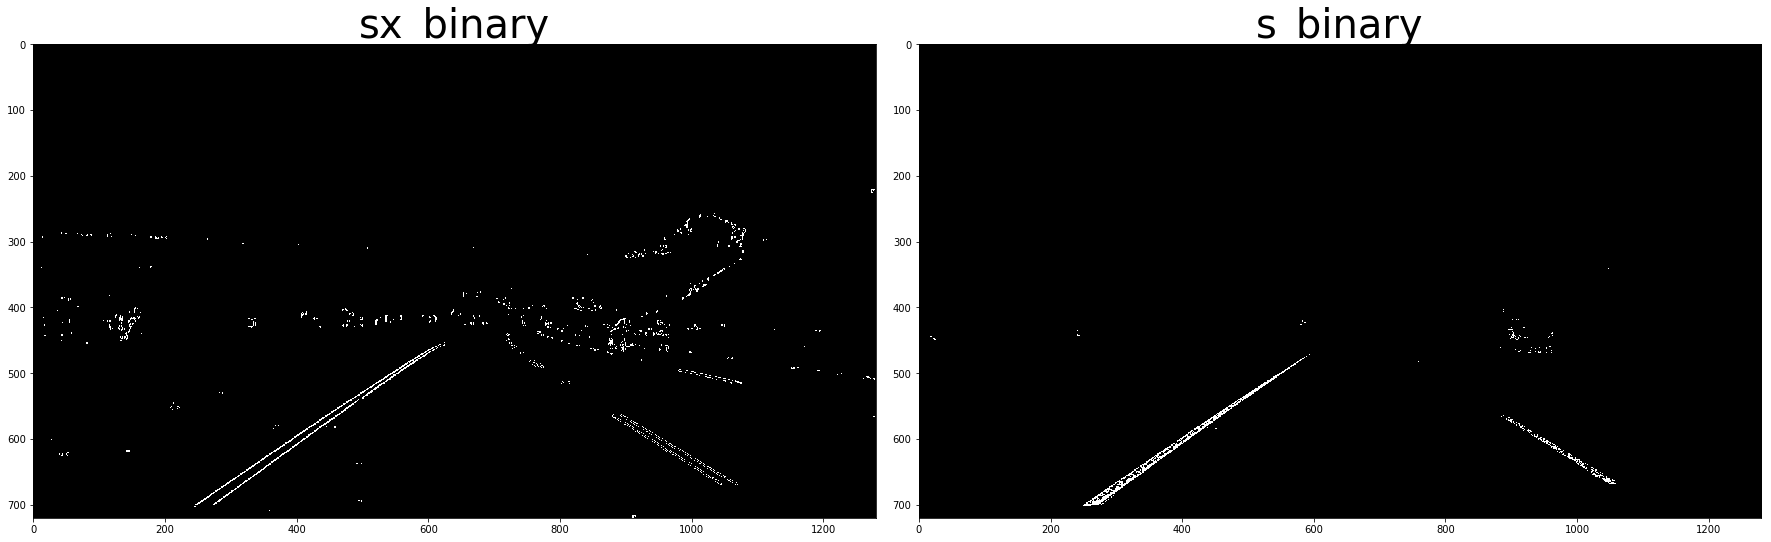

In [9]:
image = cv2.imread('test_images/test3.jpg')
show_color_gradient_pipline(image)

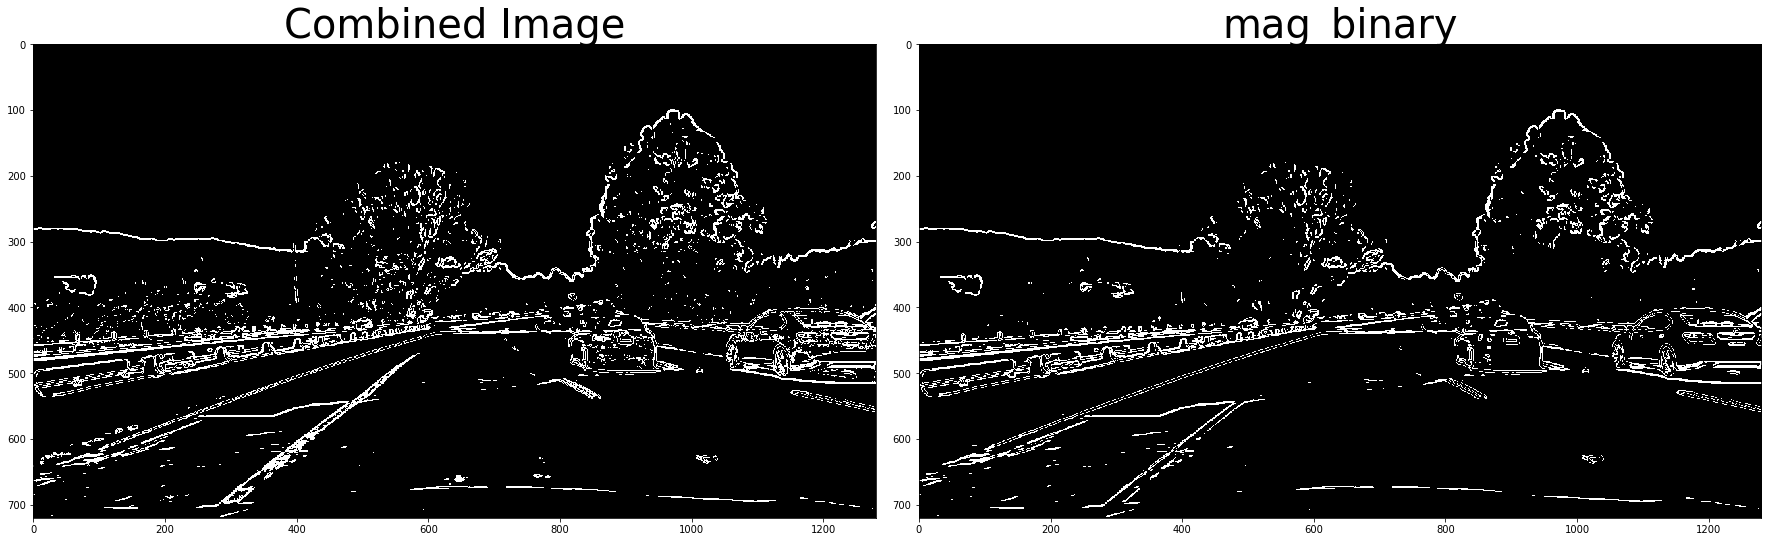

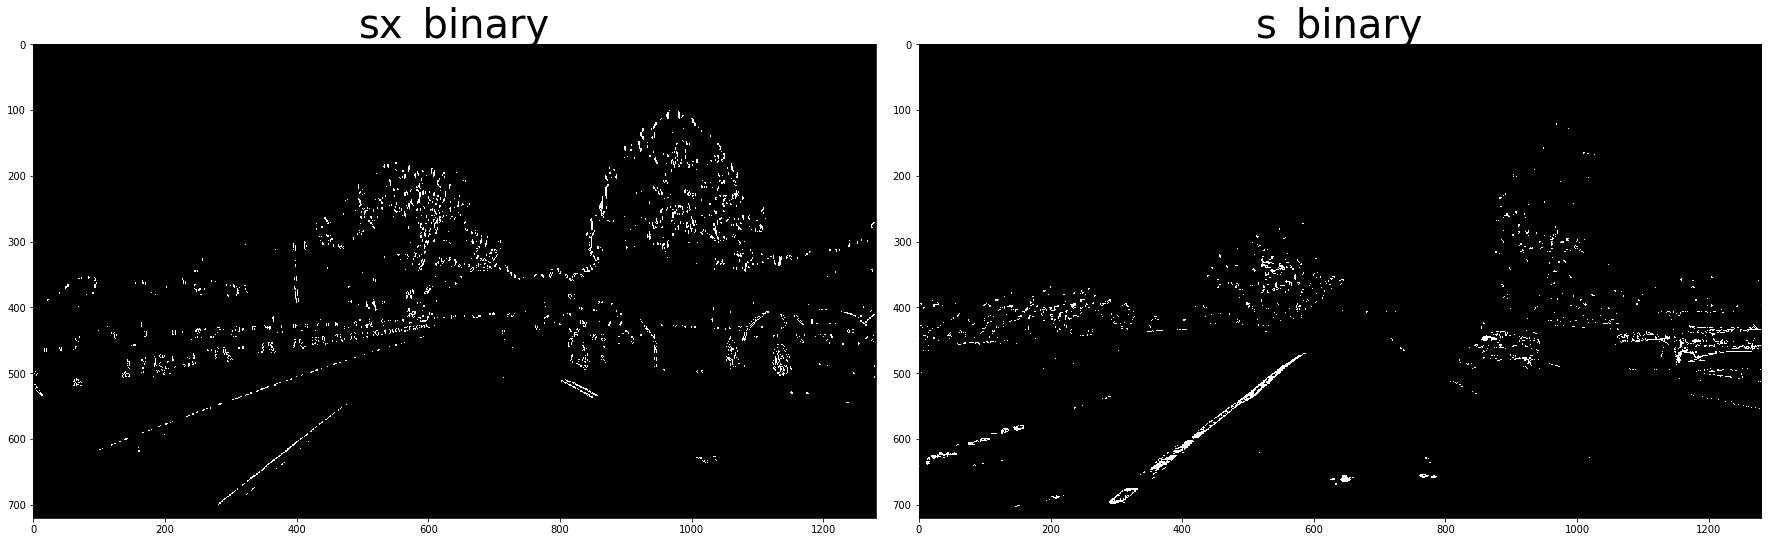

In [10]:
image = cv2.imread('test_images/test4.jpg')
show_color_gradient_pipline(image)

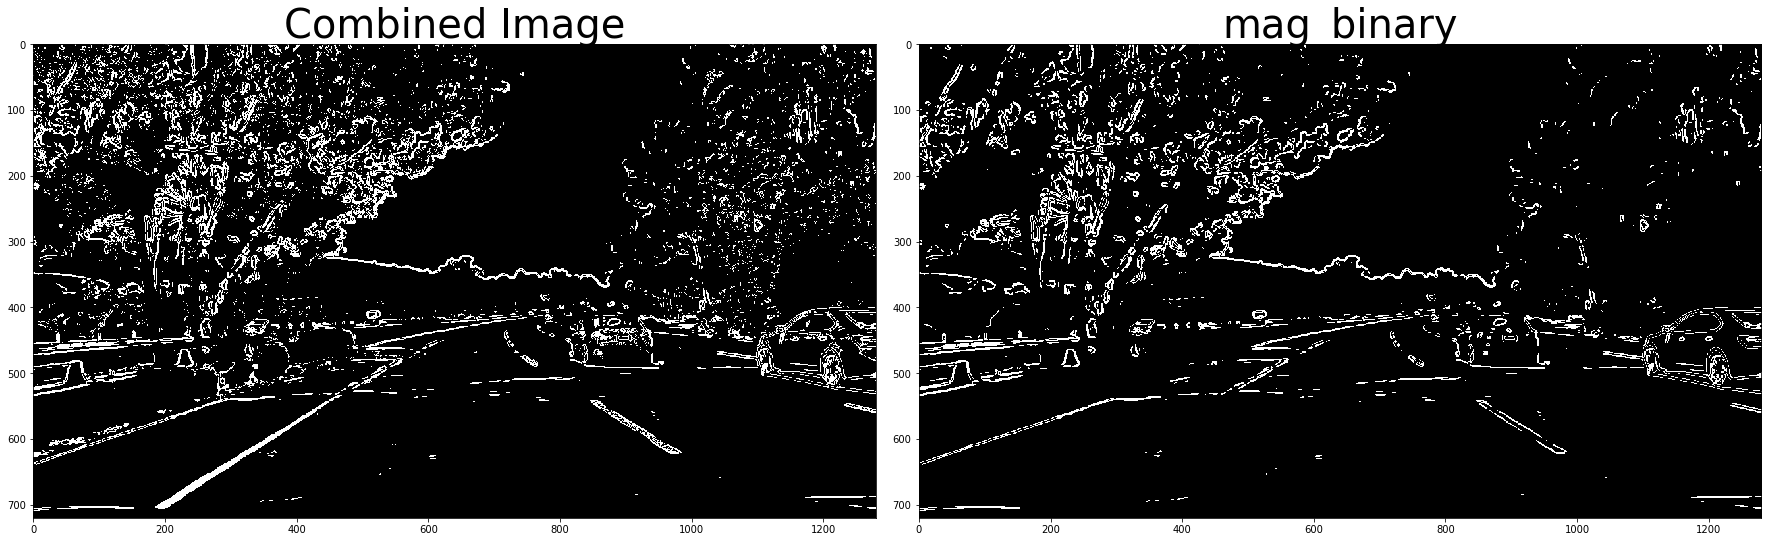

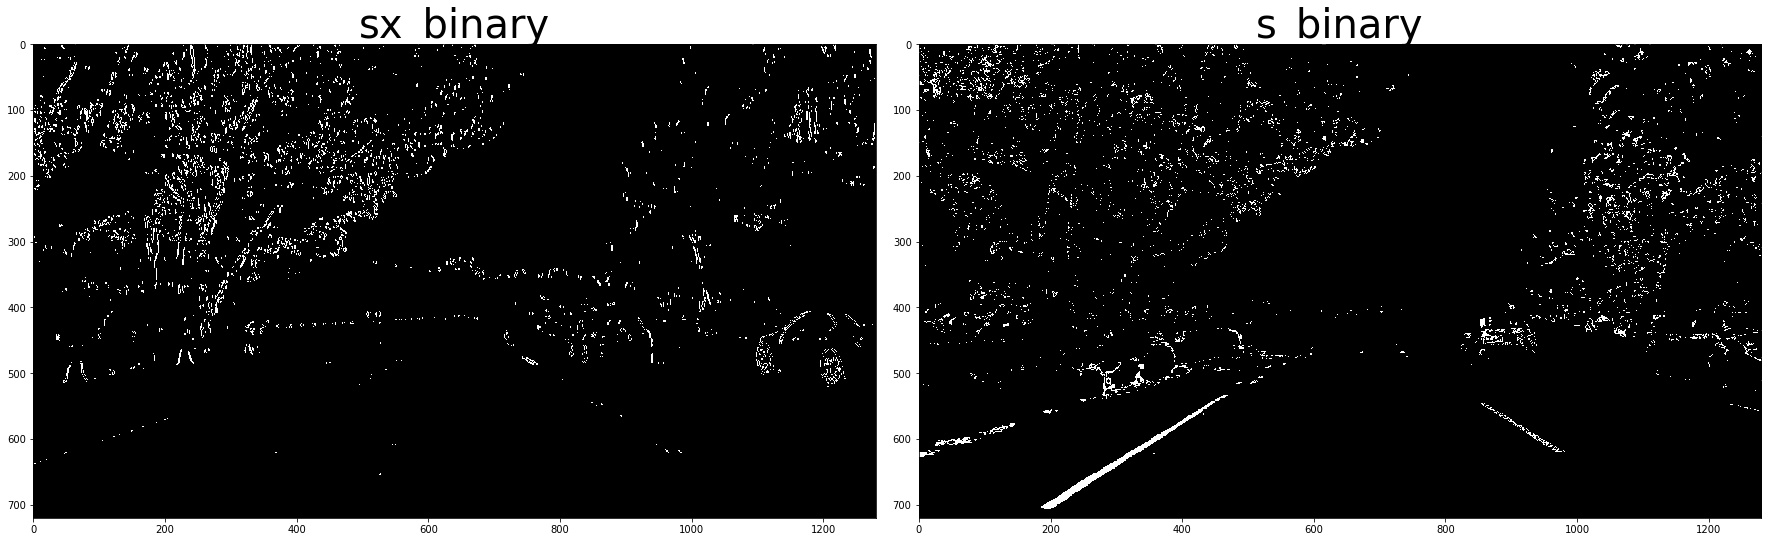

In [11]:
image = cv2.imread('test_images/test5.jpg')
show_color_gradient_pipline(image)

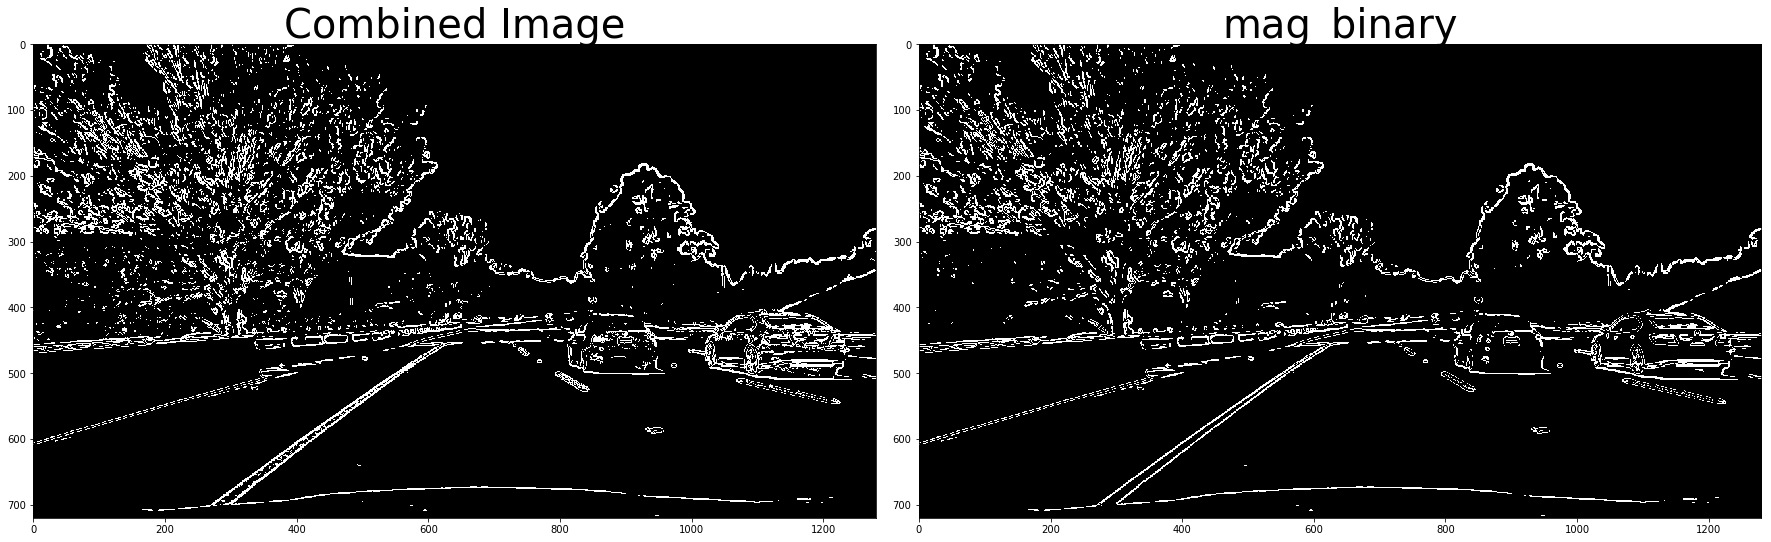

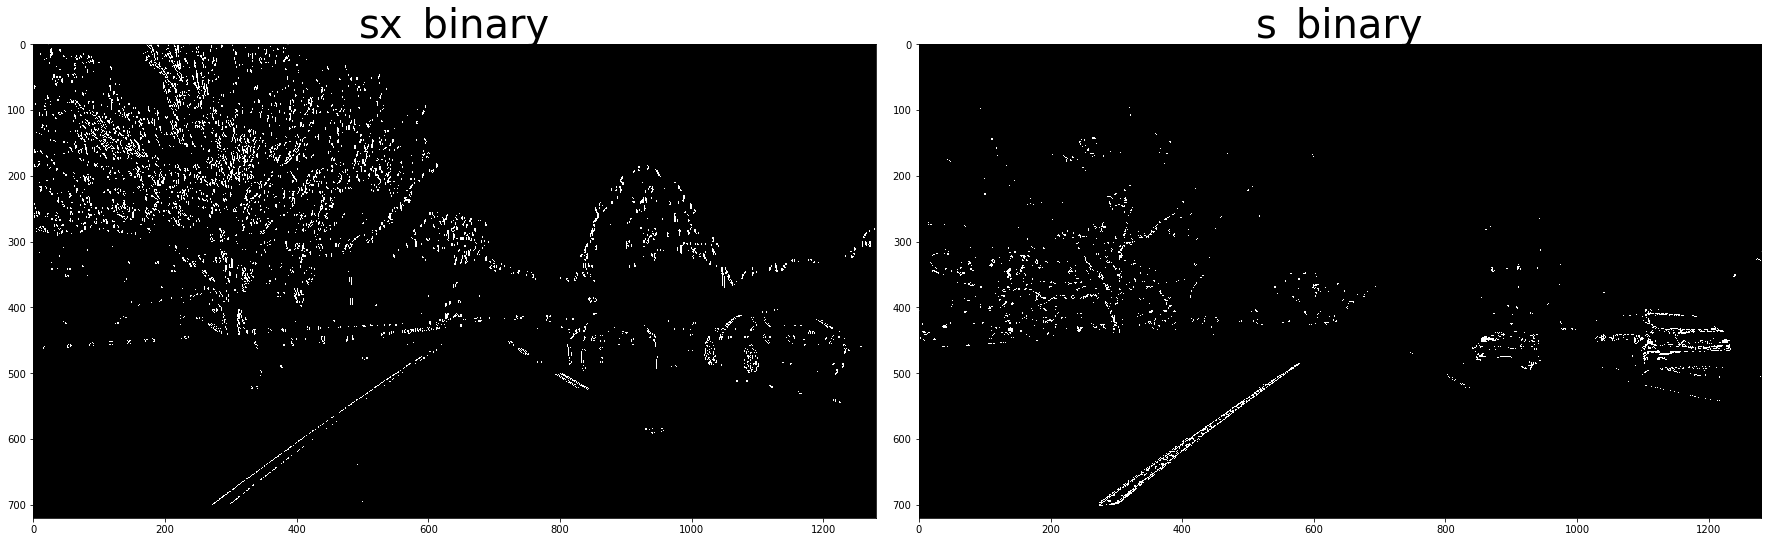

In [12]:
image = cv2.imread('test_images/test6.jpg')
show_color_gradient_pipline(image)

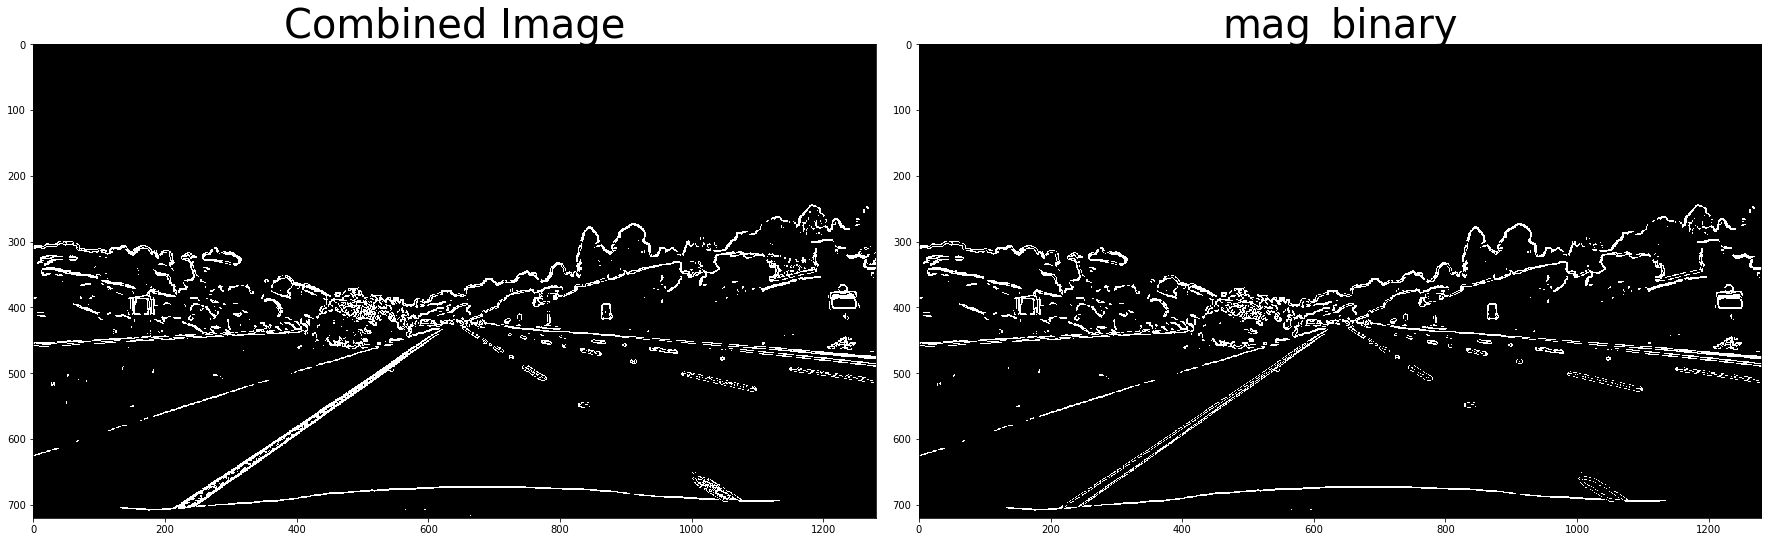

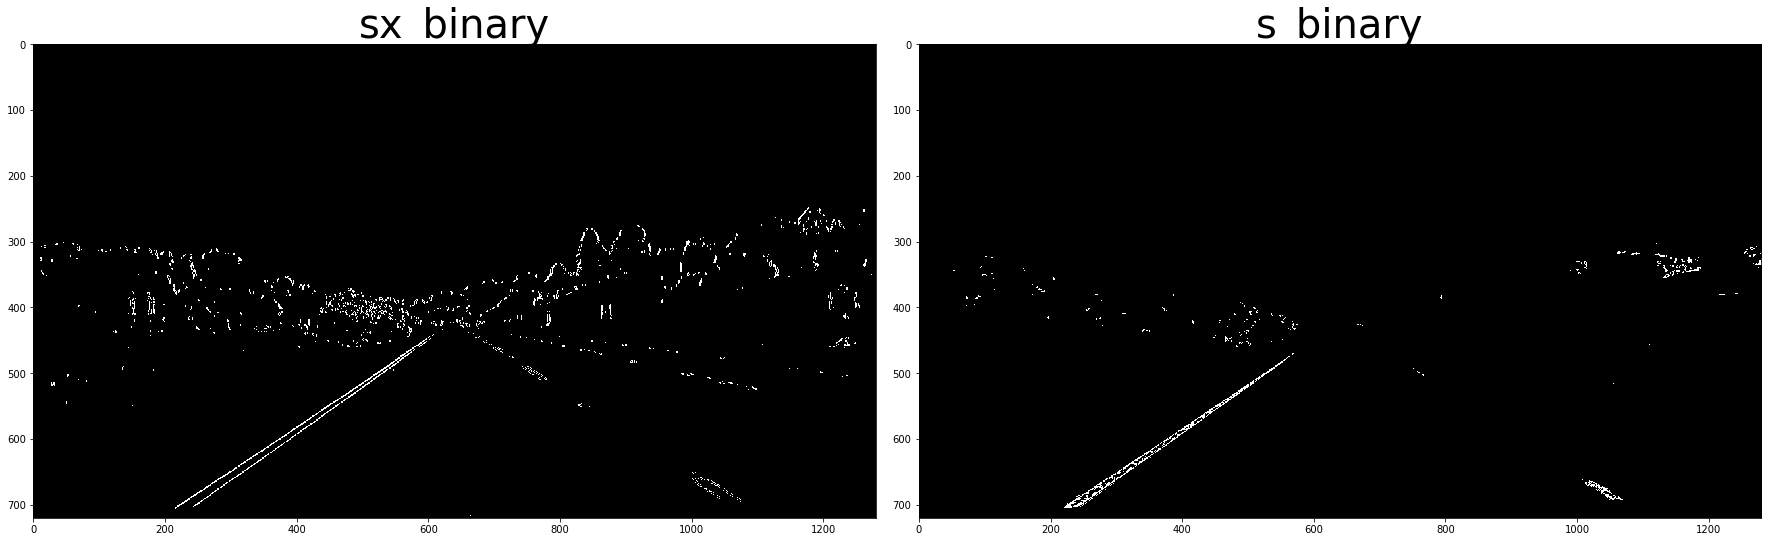

In [13]:
image = cv2.imread('test_images/straight_lines1.jpg')
show_color_gradient_pipline(image)

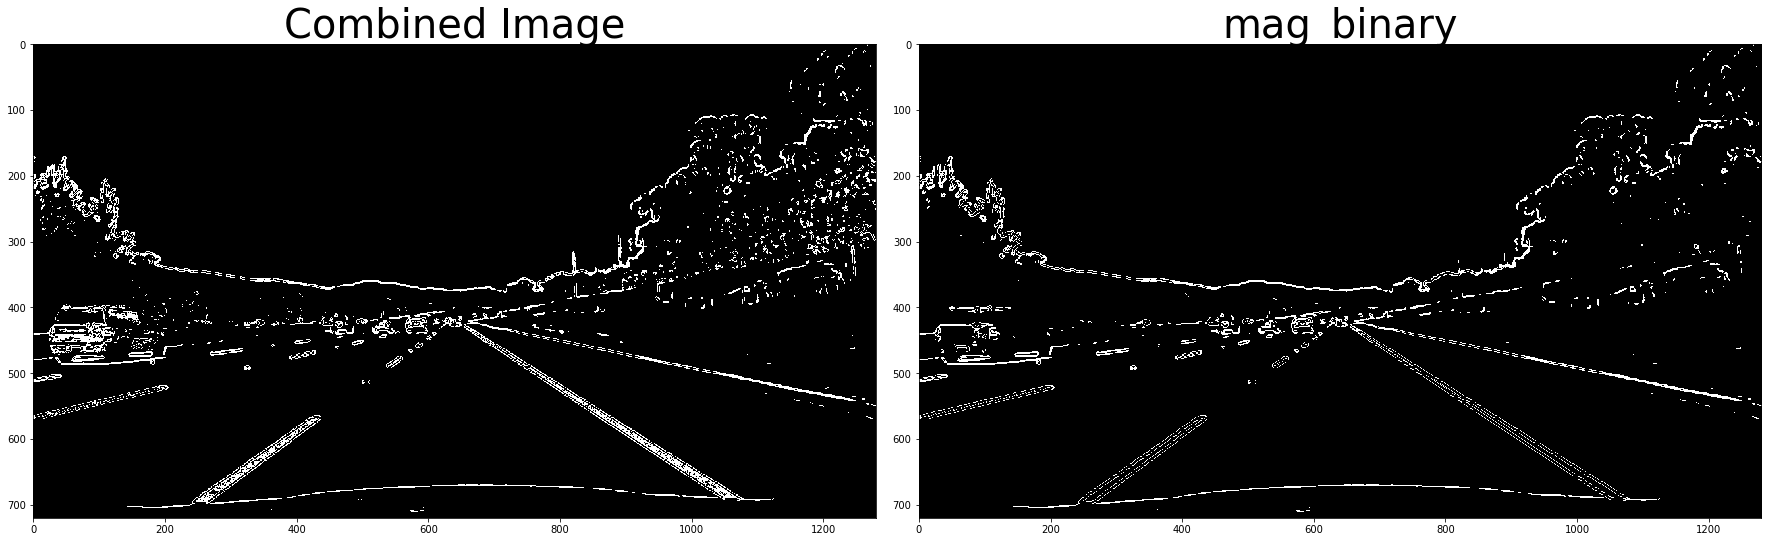

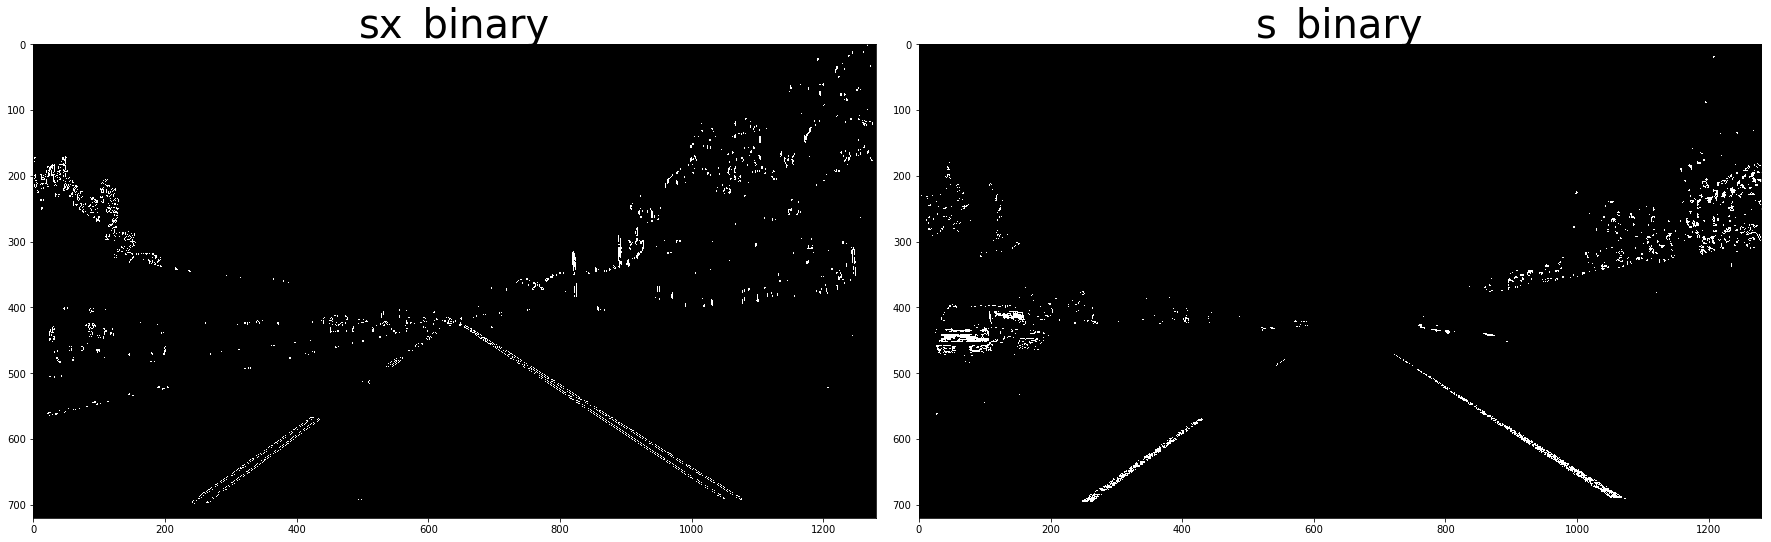

In [14]:
image = cv2.imread('test_images/straight_lines2.jpg')
show_color_gradient_pipline(image)

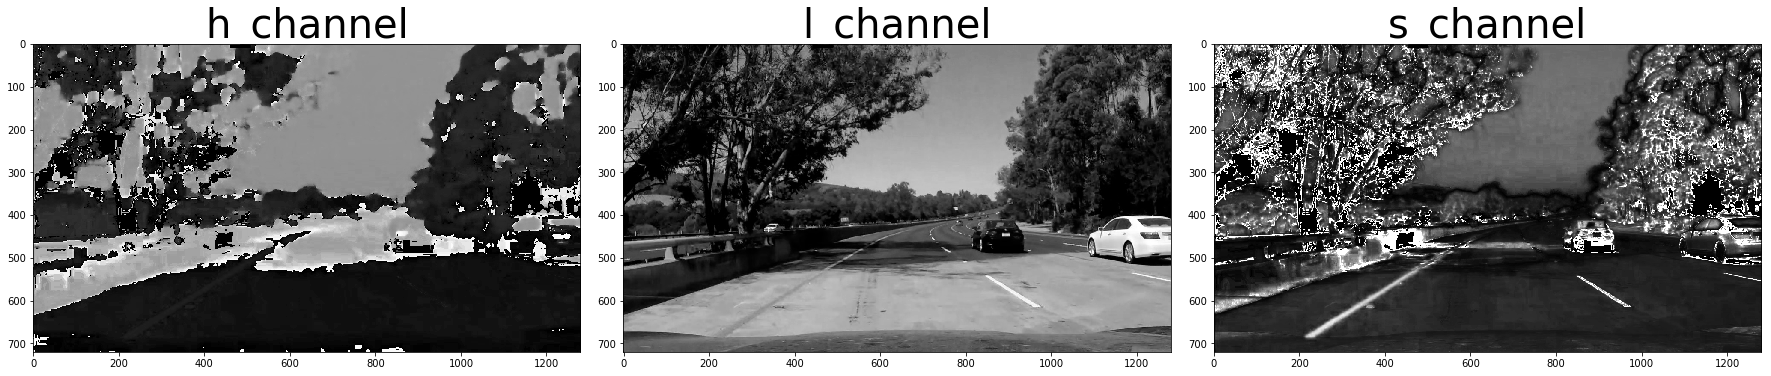

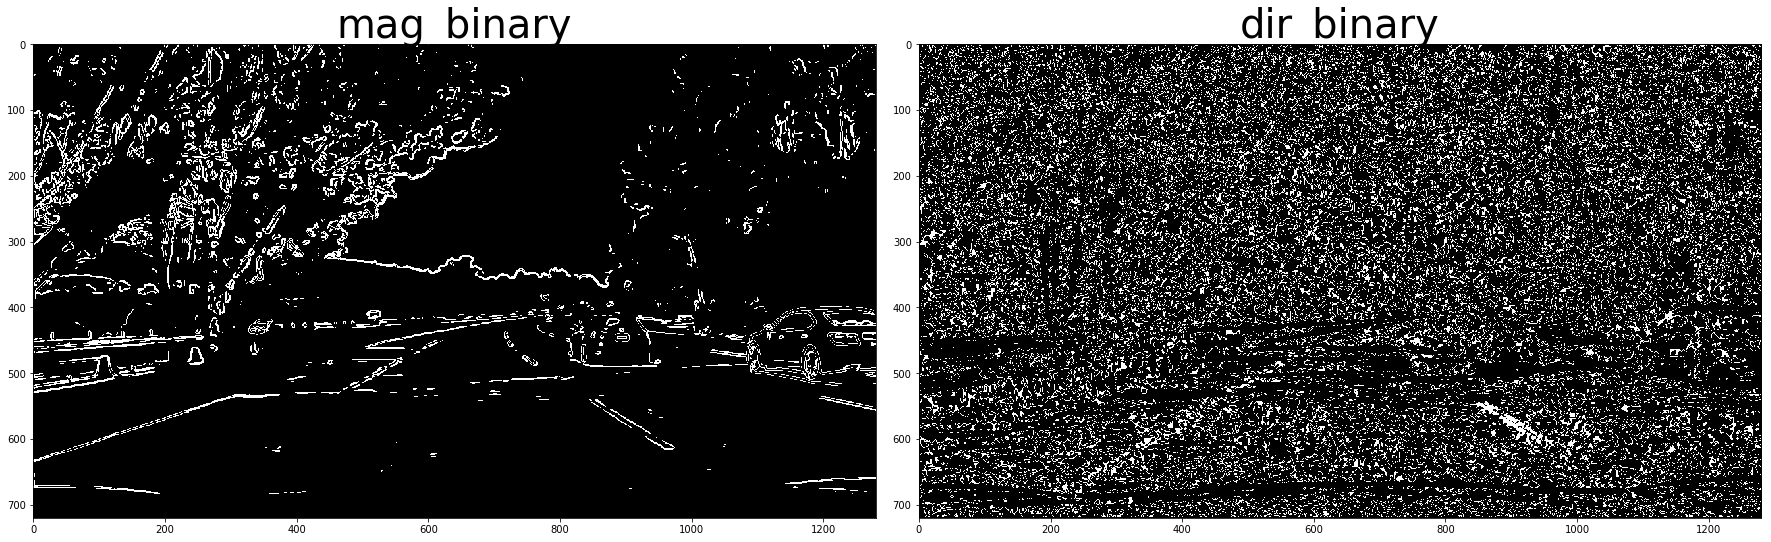

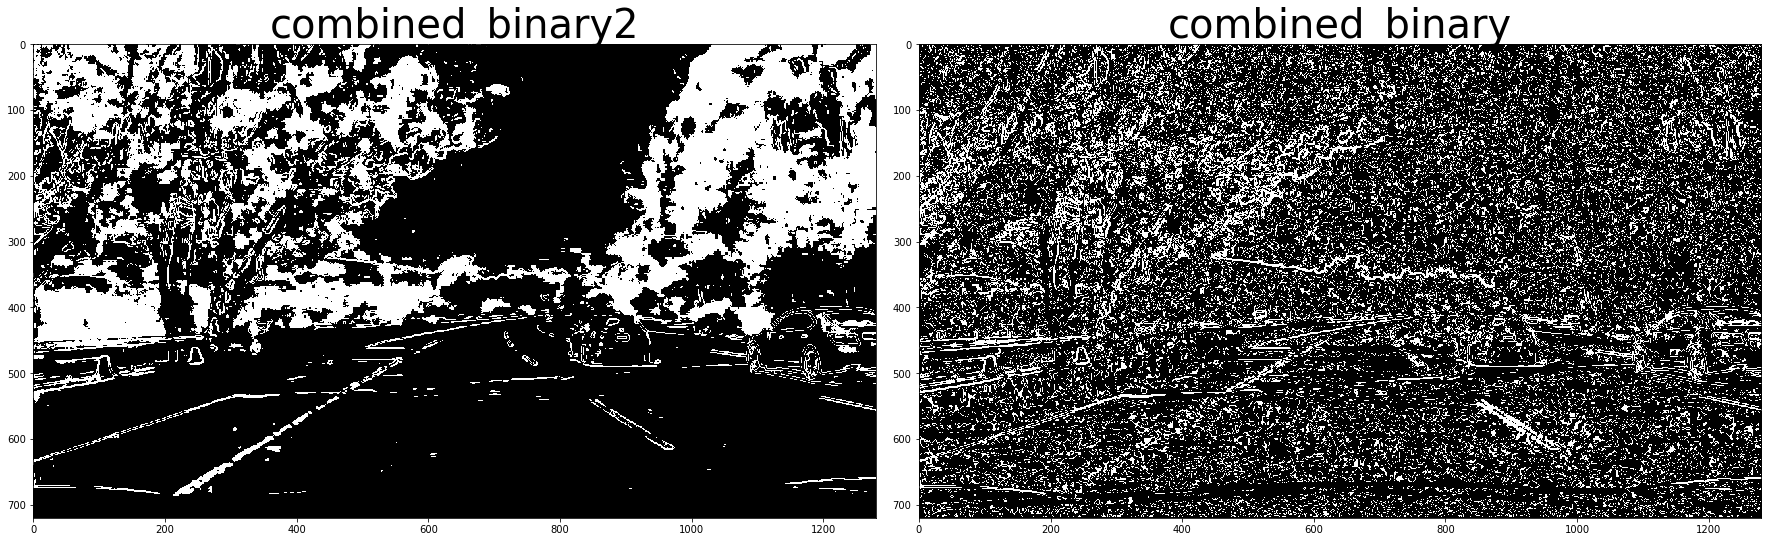

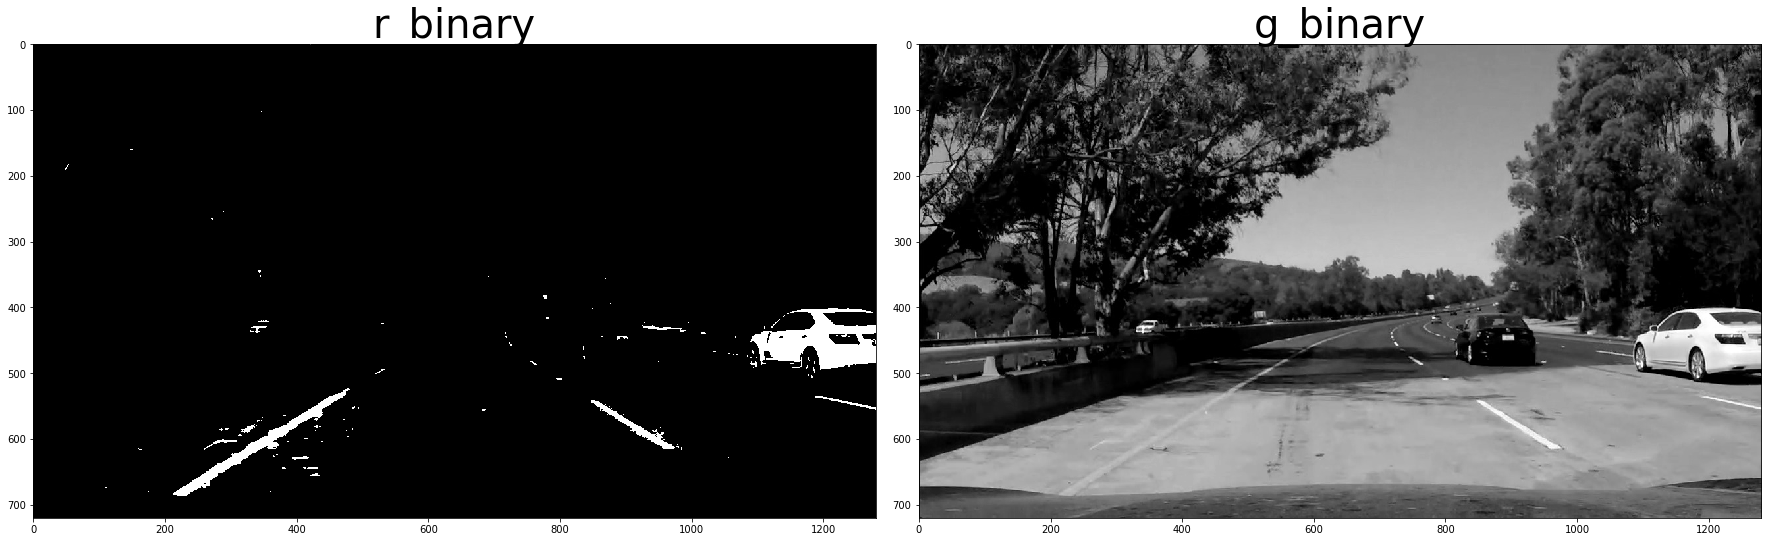

In [22]:
image = cv2.imread('test_images/test5.jpg')

# Convert to HLS color space and separate the V channel
hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]

# mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100))

# dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))

binary_output = np.zeros_like(h_channel)
binary_output[(h_channel > 20) & (h_channel <= 100)] = 1

mag_binary = mag_thresh(l_channel, sobel_kernel=9, mag_thresh=(55, 110))

dir_binary = dir_threshold(l_channel, sobel_kernel=13, thresh=(0.8, 1.1))

# Combine the two binary thresholds
combined_binary = np.zeros_like(dir_binary)
combined_binary[(mag_binary == 1) | (dir_binary == 1)] = 1

combined_binary2 = np.zeros_like(binary_output)
combined_binary2[(binary_output == 1) | (mag_binary == 1)] = 1

R = image[:,:,2]
G = image[:,:,1]
B = image[:,:,0]

r_thresh = (200, 255)
r_binary = np.zeros_like(R)
r_binary[(R > r_thresh[0]) & (R <= r_thresh[1])] = 1

g_thresh = (200, 255)
g_binary = np.zeros_like(G)
g_binary[(G > g_thresh[0]) & (G <= g_thresh[1])] = 1

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(h_channel, cmap='gray')
ax1.set_title('h_channel', fontsize=40)

ax2.imshow(l_channel, cmap='gray')
ax2.set_title('l_channel', fontsize=40)

ax3.imshow(s_channel, cmap='gray')
ax3.set_title('s_channel', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(mag_binary, cmap='gray')
ax1.set_title('mag_binary', fontsize=40)

ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('dir_binary', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(combined_binary2, cmap='gray')
ax1.set_title('combined_binary2', fontsize=40)

ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('combined_binary', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(r_binary, cmap='gray')
ax1.set_title('r_binary', fontsize=40)

ax2.imshow(G, cmap='gray')
ax2.set_title('g_binary', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

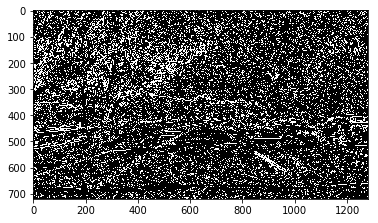

In [16]:
plt.imshow(combined_binary, cmap='gray')
plt.show()

# Region of Interest

In [17]:
def show_region_of_interest(image, region):
    cv2.line(image,(region[0][0], region[0][1]),
             (region[1][0], region[1][1]),[0, 0, 255],2)
    cv2.line(image,(region[1][0], region[1][1]),
             (region[2][0], region[2][1]),[0, 0, 255],2)
    cv2.line(image,(region[2][0], region[2][1]),
             (region[3][0], region[3][1]),[0, 0, 255],2)
    cv2.line(image,(region[3][0], region[3][1]),
             (region[0][0], region[0][1]),[0, 0, 255],2)

In [18]:
#image = cv2.imread('test_images/test6.jpg')

image = cv2.imread('test_images/straight_lines1.jpg')


color_binary, combined_binary, sx_binary, s_binary = color_gradient_pipline(image, \
                                                                            s_thresh=(125, 255), \
                                                                            sx_thresh=(50,90), m_thresh=(55, 110))

# getting image shape
imshape = combined_binary.shape

print(imshape[1])
print(imshape[0])

# setting up region in which we are interested in
vertices = np.array([[(160,imshape[0]),(imshape[1]//2-60, imshape[0]//2+80), 
                      (imshape[1]//2+60, imshape[0]//2+80), (imshape[1]-100,imshape[0])]], dtype=np.int32)


masked_image = region_of_interest(combined_binary, vertices)

show_region_of_interest(image, vertices[0])

# plt.imshow(masked_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(masked_image, cmap='gray')
ax1.set_title('masked_image', fontsize=40)

ax2.imshow(image, cmap='gray')
ax2.set_title('image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


ValueError: too many values to unpack (expected 4)

In [ ]:
def draw_cicles(img, ver):
    for v in ver:
        cv2.circle(img, tuple(v), 10, (255,0,0), -1)

In [ ]:
#image = cv2.imread('test_images/solidYellowLeft.jpg')

image = cv2.imread('test_images/test5.jpg')

color_binary, combined_binary, sx_binary, s_binary, mag_binary = color_gradient_pipline(image, \
                                                                            s_thresh=(175, 250), \
                                                                            sx_thresh=(50,90), m_thresh=(55, 110))

imshape = combined_binary.shape

offset = 100 # offset for dst points

# Grab the image shape
img_size = (combined_binary.shape[1], combined_binary.shape[0])

# print(img_size)
# For source points I'm grabbing the outer four detected corners
#src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])

# setting up region in which we are interested in
vertices = np.array([[(180,imshape[0]),(imshape[1]//2-40, imshape[0]//2+80), 
                      (imshape[1]//2+40, imshape[0]//2+80), (imshape[1]-150,imshape[0])]], dtype=np.int32)

show_region_of_interest(combined_binary, vertices[0])



src = np.float32(vertices)


print(src)
# For destination points, I'm arbitrarily choosing some points to be
# a nice fit for displaying our warped result
# again, not exact, but close enough for our purposes
# dst = np.float32([[offset, offset], [img_size[0]-offset, offset],
#                             [img_size[0]-offset, img_size[1]-offset],
#                             [offset, img_size[1]-offset]])


#dst = np.float32([[offset, img_size[1]-offset], [offset, offset], [img_size[0]-offset, offset], [img_size[0]-offset, img_size[1]-offset]])
dst = np.float32([[(300,imshape[0]),(300, 10), 
                      (imshape[1]-300,10), (imshape[1]-300,imshape[0])]])


# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)

# Warp the image using OpenCV warpPerspective()
warped = cv2.warpPerspective(combined_binary, M, img_size)

# draw_cicles(combined_binary, src[0])
# draw_cicles(warped, dst[0])

#plt.imshow(warped, cmap='gray')


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('image', fontsize=40)

ax2.imshow(warped, cmap='gray')
ax2.set_title('warped', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)